# Init 

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from os import path, listdir
from IPython.display import Video
import seaborn as sns

from utils import *
from pre_processing import *
from change_detection import *
from object_classification import *
from post_processing import *
from run_all_videos import *

warnings.filterwarnings('ignore') 

# Load Video
##### A sample video that will use as an example through the video

In [3]:
video_path = path.join('data', 'videos', 'approved.mp4')
colored_vid = load_video(video_path=video_path, gray_scale=False)
Video(video_path, height=400, width=600)

# Preprocessing

In [7]:
# Initialize a list that will be filled with all the approved objects information
approved_objects_info = []

## Histograms Calculation

### Preprocessed images outline

In [8]:
images_path = path.join('data', 'object_outline')
image_list = load_images(images_path)

### Calculating the outline histograms

In [9]:
window_size = 15 # Setting a 15X15 window size. A histogram will be calculated for each window in the image.
histograms_mean_dict = generate_histograms_mean_dict(image_list, window_size)

### Clustering the hitograms mean and calculating the mean for each cluster

In [10]:
# Cluster the images histograms mean into 2 main bins.
bins = 2
allowed_histogram_means = calculate_allowed_histograms_means(histograms_mean_dict, bins)

## Object Size calculation

### Creating a grid of the input image

In [11]:
images_path = path.join('data', 'preprocessing_images')
image_to_grid = load_images(images_path)[0] # taking the first image based on the knowledge all images sizes are the same

In [12]:
grid_size = 5 # grid the image with boxes of 5X5
image_x_grid = np.arange(0, image_to_grid.shape[1], grid_size)
image_y_grid = np.arange(0, image_to_grid.shape[0], grid_size)

In [13]:
# object_location describes the location as follows- [x, y, dx, dy].
#x,y- top left corner of the rectangle, dx,dy- length of the rectangle sides.
object_location = [600, 400, 300, 150] 
object_size_info = get_grids(image_x_grid, image_y_grid, object_location)

In [14]:
# Add the object information to 'approved_objects_info' satabase.
approved_objects_info.append({"RED": allowed_histogram_means["RED"],
                             "GREEN": allowed_histogram_means["GREEN"],
                             "BLUE": allowed_histogram_means["BLUE"],
                             "location": [object_size_info]})

# Change Detection 

## Set Parameters 

In [15]:
univariate = True
cut_percent = 100
predict = True
k=3
t=0.7
alpha=2.5
learning_rate=0.5
k_warm_up=1
model_path = path.join('data', 'models', f'{univariate}-{cut_percent}.pickle')

colored_vid = resize(colored_vid, percent=cut_percent, gray_scale=False)

if univariate:
    full_vid = load_video(video_path=video_path, gray_scale=True)
    vid = resize(full_vid, percent=cut_percent, gray_scale=True)
else:
    vid = colored_vid.copy()

## GMM

### Create Foreground Mask 

In [16]:
v_fg_mask = change_detection(vid, k=k, t=t, alpha=alpha, learning_rate=learning_rate, 
                             k_warm_up=k_warm_up, univariate=univariate, model_path=model_path, predict=predict)

  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

GMM Model loaded from a file
Start iterating over frames to detect foreground


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [06:49<00:00,  6.02s/it]


GMM Model saved to a file


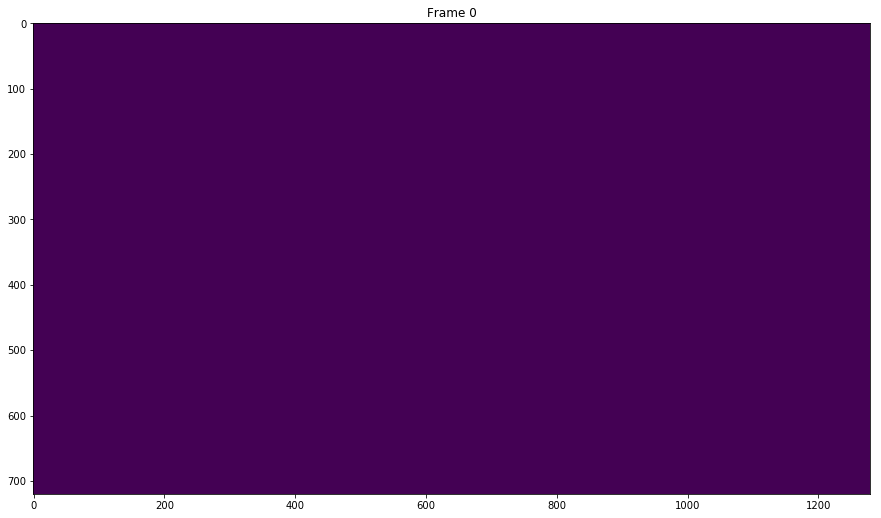

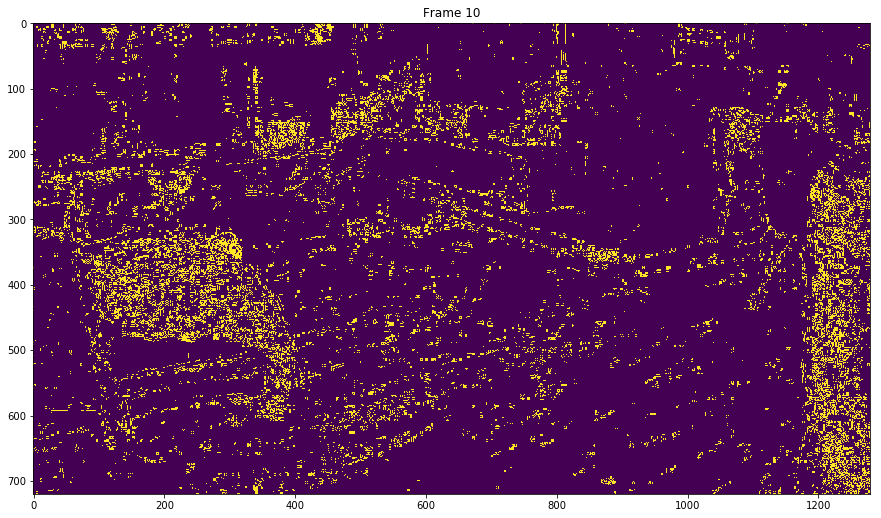

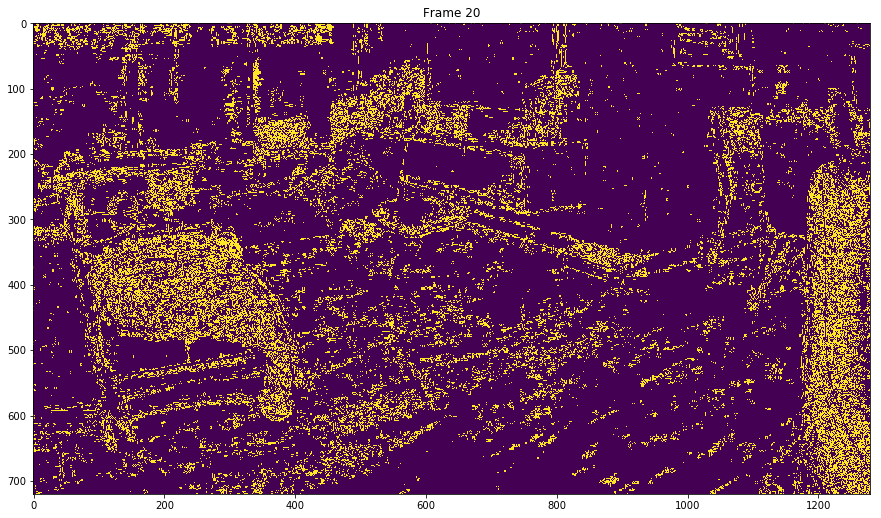

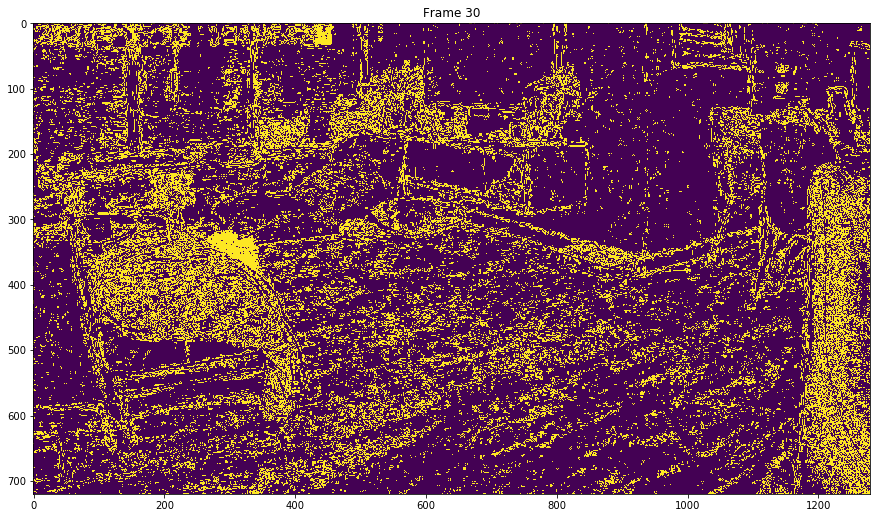

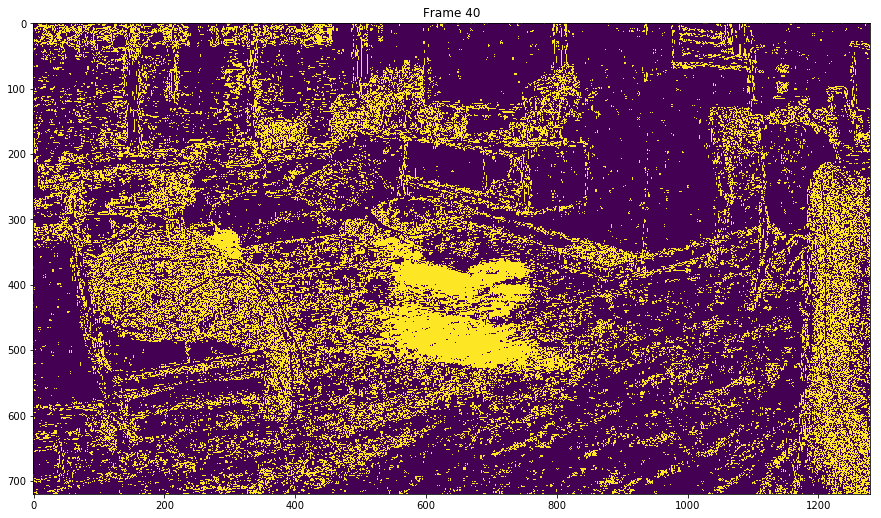

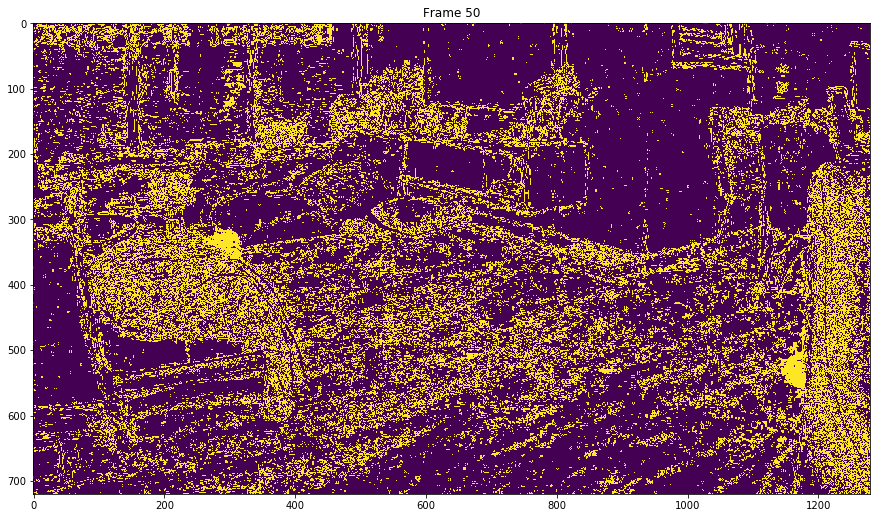

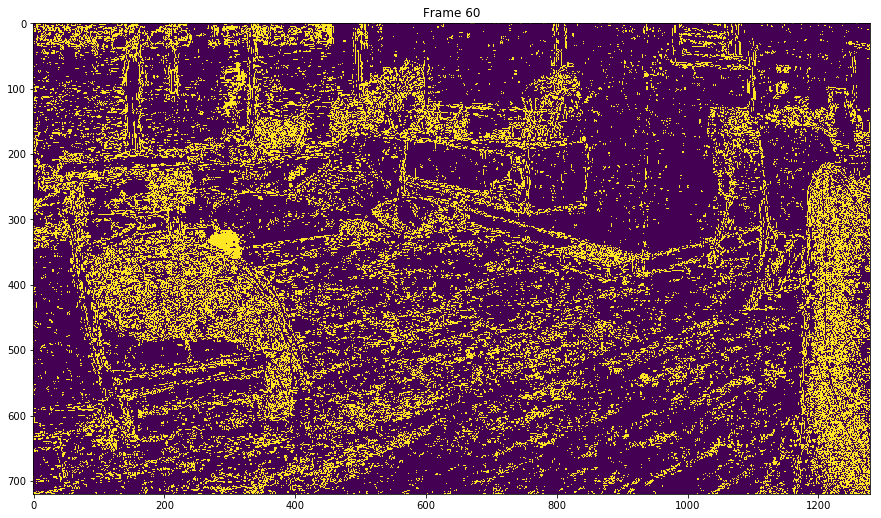

In [17]:
play_video_by_images(v_fg_mask, frame_rate=10)

### Postprocessing - Improve foreground mask

In [18]:
v_fg_mask_pp = improve_foreground(v_fg_mask)

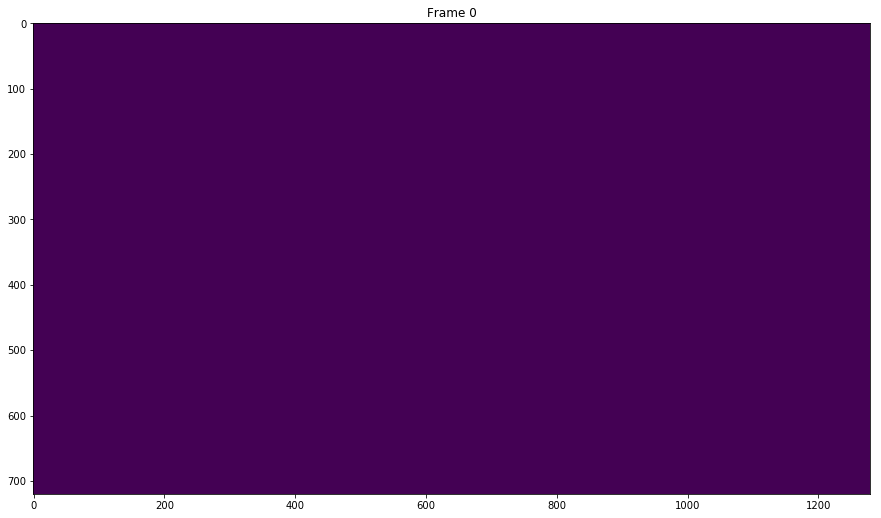

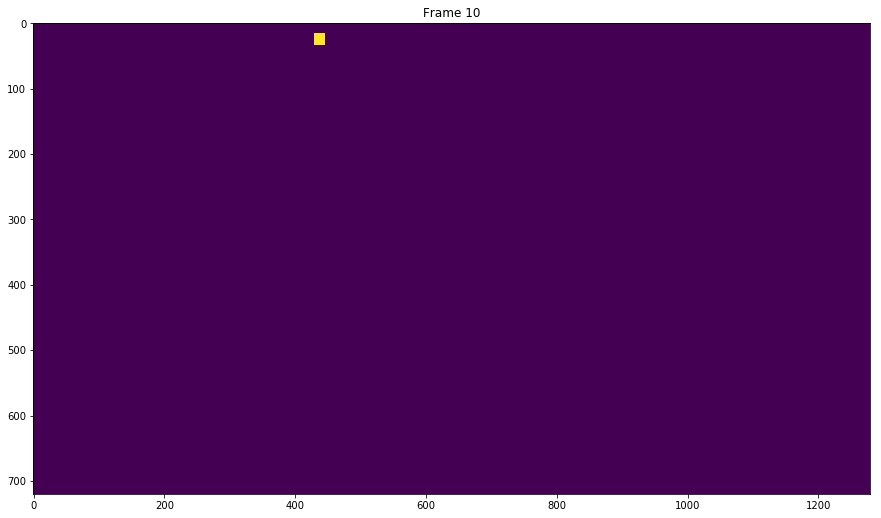

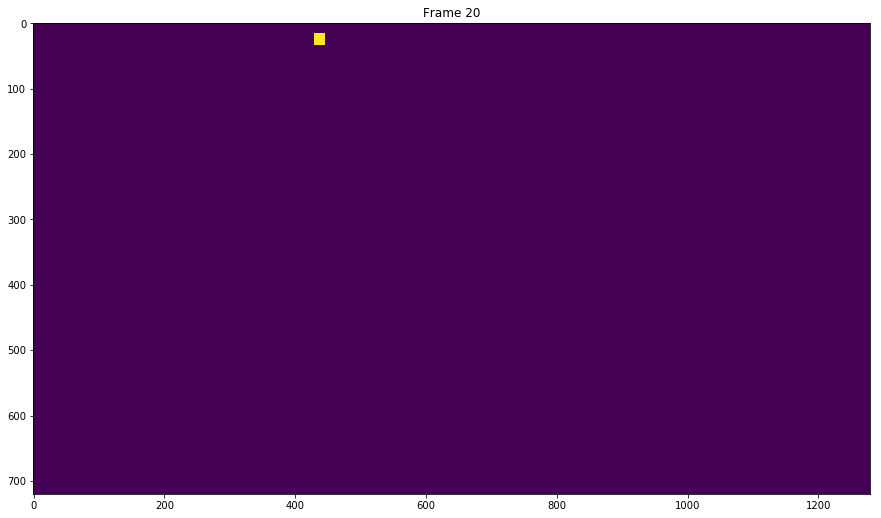

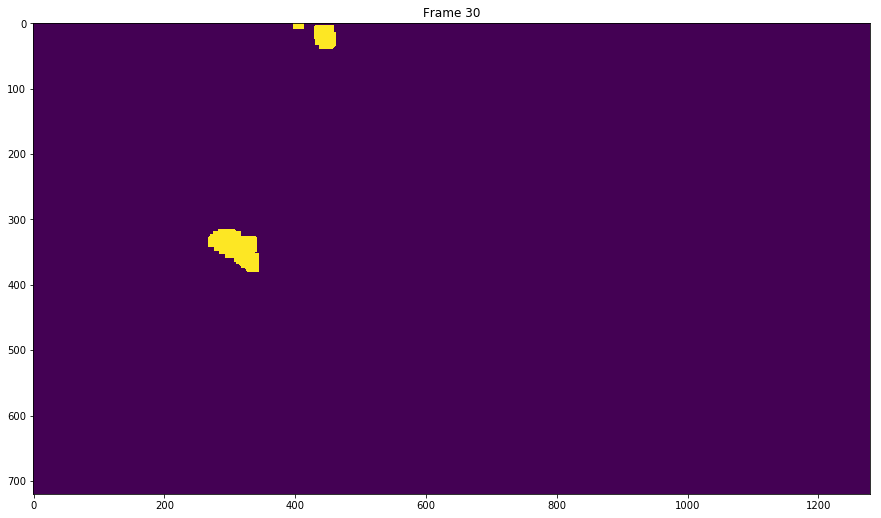

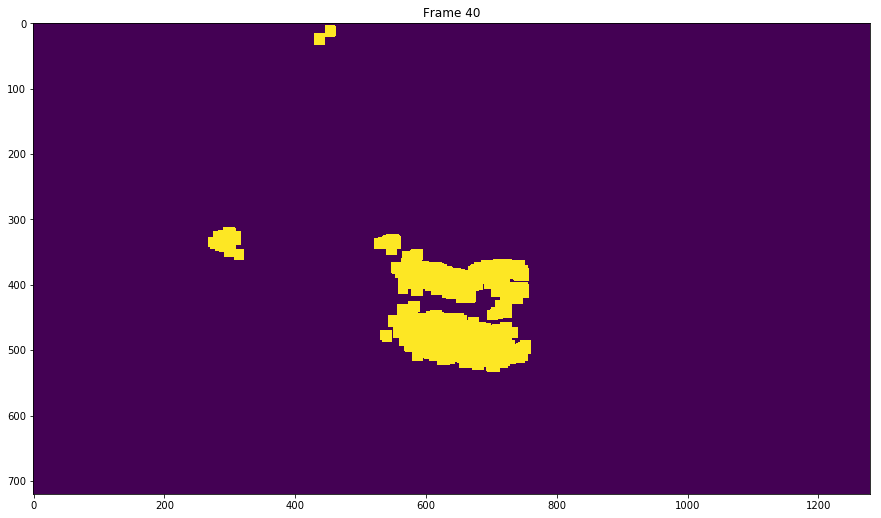

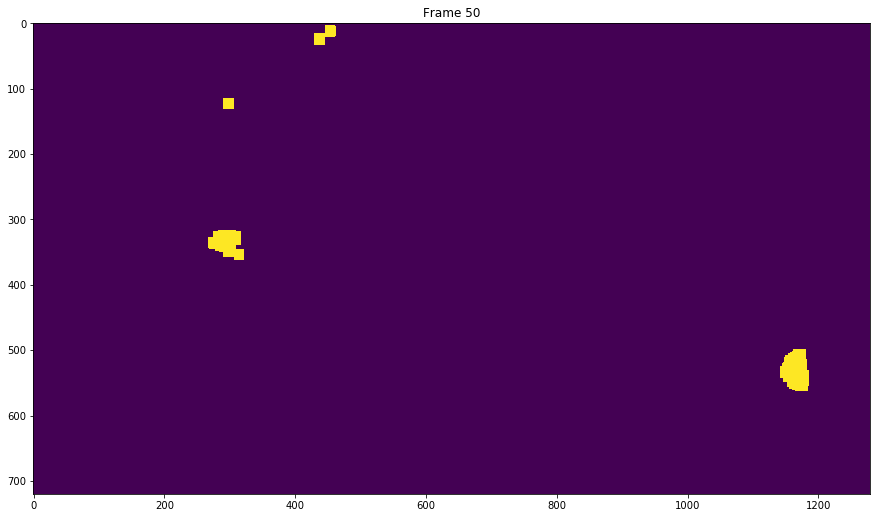

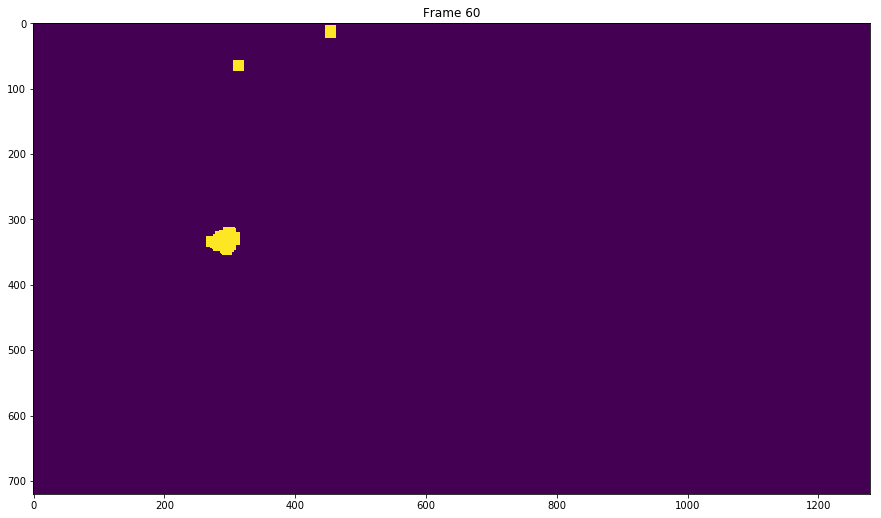

In [19]:
play_video_by_images(v_fg_mask_pp, frame_rate=10)

### Find Contours

In [20]:
frames_contours = find_contours(v_fg_mask_pp.copy())

# Object Classification 

In [ ]:
# Setting counters for total approved and unapproved objects in the scene
approved_objects_total = 0
not_approved_objects_total = 0

In [22]:
for frame_index, detected_objects_location in frames_contours.items(): # Iterating ober each frame
    frame = colored_vid[frame_index]
    num_of_objects = len(detected_objects_location)
    # get the information of the detected objects- RGB histogram and size.
    objects_info = get_detected_objects_info(frame, detected_objects_location, image_x_grid, image_y_grid, window_size)
    # Decide if the object is approved or not approved and add them to the approproiate list.
    approved_objects, not_approved_objects = match_with_approved_objects(num_of_objects, objects_info, approved_objects_info)
    # Increment counters.
    approved_objects_total += len(approved_objects)
    not_approved_objects_total += len(not_approved_objects)
    # Save the images with appropriate colord boxes wrapping them.
    save_images_with_boxes(frame, frame_index, approved_objects, not_approved_objects, detected_objects_location, out_dir = path.join('data', 'object_classification'))

## Load the result example video 

In [23]:
# We will load the frames from the previous loop and concatenate them into a new video.
image_folder = path.join('data', 'object_classification')
out_video_path = path.join(image_folder, 'video.mp4')
save_frames_video(image_folder, out_video_path)

In [24]:
Video(out_video_path, height=400, width=600)

# Measures 
##### We will execute the algorithm on 8 different videos-
##### 4 should alarm and 4 should not alarm.

In [26]:
univariate = True
cut_percent = 100
predict = True
model_path = path.join('data', 'models', 'True-100.pickle')
videos_dir_path = path.join('data', 'videos', 'measure videos')
videos_list = [video_name for video_name in listdir(videos_dir_path) if video_name.endswith('mp4')]

In [27]:
def calculate_frames_contours(video_name, k=3, t=0.7, alpha=2.5, learning_rate=0.5, k_warm_up=1, univariate=univariate,
                                                model_path=model_path, predict=predict):
    
    print(f'Change detection start for video {video_name}')
    video_path = path.join('data', 'videos', 'measure videos', f'{video_name}')
    colored_vid = load_video(video_path=video_path, gray_scale=False)

    if univariate:
        vid = load_video(video_path=video_path, gray_scale=True)
        vid = resize(vid, percent=cut_percent, gray_scale=True)
    else:
        vid = colored_vid.copy()

    v_fg_mask = change_detection(vid, k=3, t=0.7, alpha=2.5, learning_rate=0.5, k_warm_up=1, univariate=univariate,
                                 model_path=model_path, predict=predict)
    v_fg_mask_pp = improve_foreground(v_fg_mask)
    return find_contours(v_fg_mask_pp), colored_vid

In [48]:
tp = []
tn = []
fp = []
fn = []
for video_name in videos_list:
    
    frames_contours, colored_vid = calculate_frames_contours(video_name, k=3, t=0.7, alpha=2.5, learning_rate=0.5, k_warm_up=1, univariate=univariate,
                                                model_path=model_path, predict=predict)
    approved_objects_total = 0
    not_approved_objects_total = 0
    for frame_index, detected_objects_location in frames_contours.items():
        frame = colored_vid[frame_index]
        num_of_objects = len(detected_objects_location)
        objects_info = get_detected_objects_info(frame, detected_objects_location, image_x_grid, image_y_grid, window_size)
        approved_objects, not_approved_objects = match_with_approved_objects_2(num_of_objects, objects_info, approved_objects_info)
        approved_objects_total += len(approved_objects)
        not_approved_objects_total += len(not_approved_objects)
    # Setting the label to '0' if the video should be approved and to '1' if not.
    label_ = 0 if 'not_alarm' in video_name else 1
    # Setting the threshold to 0.35 to determine if the video is approved or not.
    prediction_ = 0 if approved_objects_total / (approved_objects_total+not_approved_objects_total) > 0.35 else 1

    if prediction_ == 1: print(f"{video_name} contains moving unauthorized objects")
    if prediction_ == 0: print(f"{video_name} contains moving authorized objects")

    if (label_ == 1) and (prediction_ == 1):
        tp.append(video_name)
    elif (label_ == 0) and (prediction_ == 0):
        tn.append(video_name)
    elif (label_ == 0) and (prediction_ == 1):
        fp.append(video_name)
    elif (label_ == 1) and (prediction_ == 0):
        fn.append(video_name)

    print(f'Change detection done for video {video_name}')

print(f'TP: {len(tp)}')
print(f'TN: {len(tn)}')
print(f'FN: {len(fn)}')
print(f'FP: {len(fp)}')

accuracy = (len(tp) + len(tn)) / len(videos_list)
recall = len(tp) / (len(tp) + len(fn))
precision = len(tp) / (len(tp) + len(fp))

Change detection start for video alarm1.mp4


  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

GMM Model loaded from a file
Start iterating over frames to detect foreground


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:23<00:00,  5.72s/it]


GMM Model saved to a file
alarm1.mp4 contains moving unauthorized objects
Change detection done for video alarm1.mp4
Change detection start for video alarm2.mp4


  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

GMM Model loaded from a file
Start iterating over frames to detect foreground


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [03:09<00:00,  6.10s/it]


GMM Model saved to a file
alarm2.mp4 contains moving unauthorized objects
Change detection done for video alarm2.mp4
Change detection start for video alarm3.mp4


  0%|                                                                                          | 0/201 [00:00<?, ?it/s]

GMM Model loaded from a file
Start iterating over frames to detect foreground


100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [20:30<00:00,  6.12s/it]


GMM Model saved to a file
alarm3.mp4 contains moving unauthorized objects
Change detection done for video alarm3.mp4
Change detection start for video alarm4.mp4


  0%|                                                                                          | 0/225 [00:00<?, ?it/s]

GMM Model loaded from a file
Start iterating over frames to detect foreground


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [22:39<00:00,  6.04s/it]


GMM Model saved to a file
alarm4.mp4 contains moving unauthorized objects
Change detection done for video alarm4.mp4
Change detection start for video not_alarm1.mp4


  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

GMM Model loaded from a file
Start iterating over frames to detect foreground


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:29<00:00,  5.57s/it]


GMM Model saved to a file
not_alarm1.mp4 contains moving unauthorized objects
Change detection done for video not_alarm1.mp4
Change detection start for video not_alarm2.mp4


  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

GMM Model loaded from a file
Start iterating over frames to detect foreground


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [02:00<00:00,  5.74s/it]


GMM Model saved to a file
not_alarm2.mp4 contains moving authorized objects
Change detection done for video not_alarm2.mp4
Change detection start for video not_alarm3.mp4


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

GMM Model loaded from a file
Start iterating over frames to detect foreground


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:15<00:00,  5.85s/it]


GMM Model saved to a file
not_alarm3.mp4 contains moving authorized objects
Change detection done for video not_alarm3.mp4
Change detection start for video not_alarm4.mp4


  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

GMM Model loaded from a file
Start iterating over frames to detect foreground


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [01:47<00:00,  5.98s/it]


GMM Model saved to a file
not_alarm4.mp4 contains moving unauthorized objects
Change detection done for video not_alarm4.mp4
TP: 4
TN: 2
FN: 0
FP: 2


In [49]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

Precision: 0.6666666666666666
Recall: 1.0
Accuracy: 0.75


## Plotting Confusion Matrix

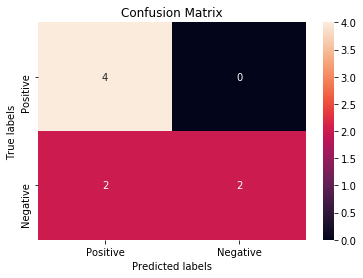

In [50]:
conf_matrix = np.array([[len(tp), len(fn)],[len(fp), len(tn)]])

ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Positive', 'Negative']); ax.yaxis.set_ticklabels(['Positive', 'Negative']);